<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Data_analysisHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the second dataset 

In [19]:
#@title
import zipfile
import io
import cv2
import glob 
import numpy as np
import random 
import torch 
device = 'cuda'
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive

torch.manual_seed(0) # Reproducible, for now 

FIGSIZE = (12,10)

!rm -rf main_dir
!rm -rf data.zip

drive.mount('/content/drive/')
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/HD/data2/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

import sys
sys.path.append('local_modules')

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/utils.py’ already there; not retrieving.



In [0]:
#transf_temp =  transforms.Compose( [ToTensor()])
#train_data_temp = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf_temp)
#dataloader_temp = DataLoader(train_data_temp, batch_size = 64, shuffle = True, num_workers = 0)
#MEAN, STD = utils.datasetMeanStd(dataloader_temp)
MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])
train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
val_data = ImageFolder(root = os.path.join(root_dir, 'val'), transform = transf)
test_data = ImageFolder(root = os.path.join(root_dir, 'test'), transform = transf)


# Dataset description 


*   Label 0: the image doesn't contain any shape 
*   Label 1: the image contains at least one shape 

Here are two examples: 



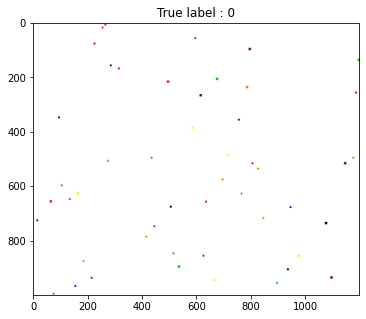

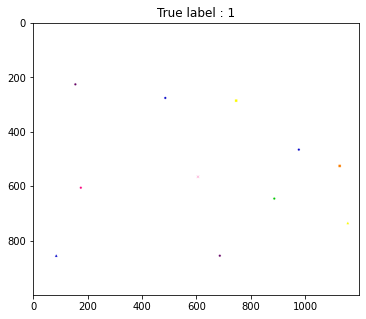

In [21]:
img0 = utils.input2image(train_data[0][0], MEAN, STD)
img1 = utils.input2image(train_data[-1][0], MEAN, STD)
utils.display_image(img0, train_data[0][1])      
utils.display_image(img1, train_data[-1][1])     

In [0]:
batch_Size = 64
dataloader = DataLoader(train_data, batch_size = batch_Size, shuffle = True, num_workers = 0)
valloader = DataLoader(val_data, batch_size = batch_Size, shuffle = True, num_workers = 0)
testloader = DataLoader(test_data, batch_size = batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
x,y = next(train_loader)

# Model description
The neural network used to classify the images receives batches of 3x100x120 images. 
It consists of 
* two convolutional layers followed by max pooling 
* three fully connected layers

In [0]:
class HD_Net(nn.Module):
    def __init__(self):
        super(HD_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride=5)
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv1 = nn.Conv2d(6, 10, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 16, 4)
        self.pool2 = nn.MaxPool2d(5)
        self.fc1 = nn.Linear(16 * 9 * 11, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.pool0(x)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, self.num_flat_features(x))  # 16*9*11
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


def datasetMeanStd(loader):
    # Computes the mean and standard deviation of a DataLoader of 3 channel images
    mean = 0.
    std = 0.
    N = len(loader.dataset)
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= N
    std /= (N-1)
    return mean.numpy(), std.numpy()


def denormalize(im, mean, std):
  return im*std + mean

def input2image(input, mean, std):
    sample_image = input.numpy().transpose(1, 2, 0)
    return denormalize(sample_image, mean, std)

def display_image(im, true_label, predicted_label=None, figure_size = (8, 5)):
    plt.figure(figsize=figure_size)
    plt.imshow(im)
    title_ = "True label : " + str(true_label)
    if (predicted_label != None):
        title_ += "/ Predicted : " + str(predicted_label)
    plt.title(title_)

def almost_equal(n1, n2, e):
  return abs(n1-n2) < e

def network_has_converged(loss, e):
  if (len(loss) < 3):
    return False
  else:
    return (almost_equal(loss[-3], loss[-2], e) and
            almost_equal(loss[-3], loss[-1], e) )

def training_accuracy(network, loader):
  with torch.no_grad():
    correct = 0
    total = 0
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = network(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct/total

def validation_stats(network, loader, criterion):
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)

          outputs = network(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          total_loss += loss.item()

    return (100 * correct/total, total_loss/len(loader.dataset))

def plot_training(train_loss, val_loss, train_accuracy, val_accuracy):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    x_scale = np.linspace(0, len(train_loss)- 1, len(train_loss) )
    _ = ax1.plot(x_scale, train_loss)
    _ = ax1.plot(x_scale, val_loss)
    ax1.legend(["Loss on the training set", "Loss on the validation set"])
    ax1.set_xlabel("Number of generations")
    ax1.set_ylabel("Evaluation of the loss function")

    x_scale = np.linspace(0, len(train_accuracy)- 1, len(train_accuracy) )
    _ = ax2.plot(x_scale, train_accuracy)
    _ = ax2.plot(x_scale, val_accuracy)
    ax2.legend(["Training accuracy", "Validation accuracy"])
    ax2.set_xlabel("Number of generations")
    ax2.set_ylabel("Accuracy ")


def test(net, loader):
    correct = 0
    total = 0
    wrong_im = []
    wrong_label = []
    wrongly_predicted_label = []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            k = 0
            for truth in (predicted == labels):
                if not truth:
                    wrong_im.append(images[k])
                    wrong_label.append(int(labels[k]))
                    wrongly_predicted_label.append(int(predicted[k]))
                k += 1

    print("Accuracy of the network on the " + str(total) + ' test images: %.3f %%' % (
            100 * correct / total))

    print("Number of mistakes : " + str(total - correct))
    return wrong_im, wrong_label, wrongly_predicted_label


def train(net, optimizer, criterion, max_epochs, dataloader, valloader ):
    converged = False
    epsilon = 0.0001
    train_loss, val_loss, train_accuracy, val_accuracy = [], [], [], []
    for epoch in range(max_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        if not converged:
            for i, data in enumerate(dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                # plot loss
                running_loss += loss.item()

            train_loss.append(running_loss / len(dataloader.dataset))
            train_accuracy.append(training_accuracy(net, dataloader))
            A, L = validation_stats(net, valloader, criterion)
            val_loss.append(L)
            val_accuracy.append(A)

            print('Generation %d. training loss: %.4f,'
                  % (epoch + 1, train_loss[-1]), end="")
            print(" training accuracy: %.2f " % (train_accuracy[-1]), end="%,")
            print(" validation loss: %.4f," % (val_loss[-1]), end=" ")
            print(" validation accuracy: %.2f " % (val_accuracy[-1]), end="% \n")

            converged = network_has_converged(train_loss, epsilon)

    if (converged):
        print("Network has converged.")
    else:
        print("Network hasn't been able to converge in " + str(max_epochs) + " generations.")
    return train_loss, val_loss, train_accuracy, val_accuracy


Generation 1. training loss: 0.0109, training accuracy: 50.06 %, validation loss: 0.0111,  validation accuracy: 50.40 % 
Generation 2. training loss: 0.0103, training accuracy: 54.06 %, validation loss: 0.0102,  validation accuracy: 53.70 % 
Generation 3. training loss: 0.0030, training accuracy: 96.94 %, validation loss: 0.0016,  validation accuracy: 97.90 % 
Generation 4. training loss: 0.0006, training accuracy: 99.85 %, validation loss: 0.0002,  validation accuracy: 99.70 % 
Generation 5. training loss: 0.0001, training accuracy: 99.94 %, validation loss: 0.0001,  validation accuracy: 99.90 % 
Generation 6. training loss: 0.0000, training accuracy: 99.99 %, validation loss: 0.0001,  validation accuracy: 99.90 % 
Generation 7. training loss: 0.0000, training accuracy: 100.00 %, validation loss: 0.0001,  validation accuracy: 99.90 % 
Network has converged.
Accuracy of the network on the 2000 test images: 100.000 %
Number of mistakes : 0


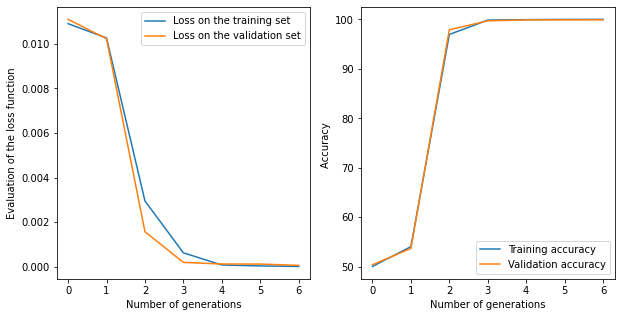

In [18]:
net = HD_Net().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters()) 
max_epochs = 50
train_loss, val_loss, train_accuracy, val_accuracy = train(net, optimizer, criterion, max_epochs, dataloader, valloader)
plot_training(train_loss, val_loss, train_accuracy, val_accuracy)
wi, wl, wpl = test(net, testloader)
index = 0

In [0]:
if index in range(len(wi)):
  I = utils.input2image(wi[index], MEAN, STD)
  utils.display_image(I, wl[index], wpl[index])
  outputs = net(wi[index].unsqueeze(0)).data
  print("Score for predicted label: ", outputs.numpy()[0][wpl[index]])
  print("Score for true label: ", outputs.numpy()[0][wl[index]])
  index += 1

In [0]:
index = 0

In [23]:
save = input("Overwrite current state dictionnary ? [y/n]")
if (save == 'y'): 
  torch.save(net.state_dict(), 'drive/My Drive/Interpretability/modelHD.pth')
  print("State dictionnary saved.")
else: 
  print("State dictionnary has not been saved.")

Overwrite current state dictionnary ? [y/n]y
State dictionnary saved.
